In [ ]:
%cd '/content/drive/MyDrive/MIDAS Internship/Task 2/Training 0-9/Train'

/content/drive/MyDrive/MIDAS Internship/Task 2/Training 0-9/Train


## Importing all the necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage import io
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline

## Defining the Data Generators
Used to Load the Training and Validation data on the fly directly from the drive to train along with Data Augmentations

In [ ]:
input_shape = (28, 28, 1)
img_width = 28
img_height = 28
num_classes = 10
batch_size = 32
epochs = 10

train_data_dir = './'

datagen_args = dict( 
    rescale=1./255 ,
    rotation_range=10,
    zoom_range = 0.10,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    fill_mode = 'nearest',
    validation_split=0.2)
datagen = ImageDataGenerator(**datagen_args)
datagenerator = datagen.flow_from_directory(
    './',target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode = 'categorical',
    # interpolation="lanczos",
    shuffle=True , 
    subset='training')

validation_generator = datagen.flow_from_directory(
    './', 
    target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode = 'categorical',
    # interpolation="lanczos",
    shuffle=False ,
    subset='validation')

Found 320 images belonging to 10 classes.
Found 80 images belonging to 10 classes.


## Some Specifications of the Training data

In [ ]:
print("Number of Samples in training : " , datagenerator.samples)
print("Number of Classes : " , len(datagenerator.class_indices))
print("Number of Samples per class : " , datagenerator.samples // len(datagenerator.class_indices))

Number of Samples in training :  320
Number of Classes :  10
Number of Samples per class :  32


## An example of a batch of data load from the drive on the file using Data Generators

In [ ]:
x,y = next(datagenerator)
print("x.shape : " , x.shape)
print("y.shape : " , y.shape)


x.shape :  (32, 28, 28, 1)
y.shape :  (32, 10)


## Dynamically Plot the Training and validation loss with each epoch 
To be used as a callback Function

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt 
import keras

class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

## Defining the Best model Architecture
Derived from the experimentations conducted in Part 1

In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 1
model1 = [0] *nets

j=0
model1[j] = Sequential()
model1[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=input_shape))
model1[j].add(MaxPooling2D())
model1[j].add(Dropout(0.1))
model1[j].add(Conv2D(64,kernel_size=5,activation='relu'))
model1[j].add(MaxPooling2D())
model1[j].add(Dropout(0.1))
model1[j].add(Flatten())
model1[j].add(Dense(256, activation='relu'))
model1[j].add(Dropout(0.1))
model1[j].add(Dense(10, activation='softmax'))
model1[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Compiling the new Model 


*   annealer : Used to decrease the learning rate in each epoch
*   cp_callback : Used to checkpoint the model if validation accuracy increases
*   plot_losses : Used to plot the training and Validation Loss at with epoch 
*   model.fit_generator : Augments the data and trains the model on it







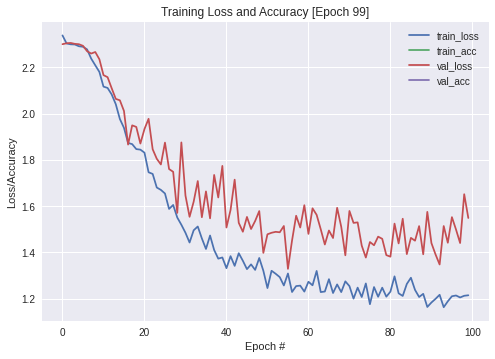

CNN 1: Epochs=100, Train accuracy=0.66250, Validation accuracy=0.62500


In [ ]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

checkpoint_path = "/content/drive/MyDrive/MIDAS Internship/Task 2/Training 0-9/train_ckpt/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', mode='max',save_best_only=True, verbose=1)

# TRAIN NETWORKS
history = [0] * nets
epochs = 100
for j in range(nets):

  history[j] = model1[j].fit_generator(datagenerator, 
                           steps_per_epoch= datagenerator.samples // batch_size,
                           epochs=epochs, 
                           validation_data=validation_generator, 
                           validation_steps=validation_generator.samples // batch_size, 
                          #  verbose=0, 
                           callbacks=[cp_callback,plot_losses,annealer],
                           workers=8
                           )
  print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                                    j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

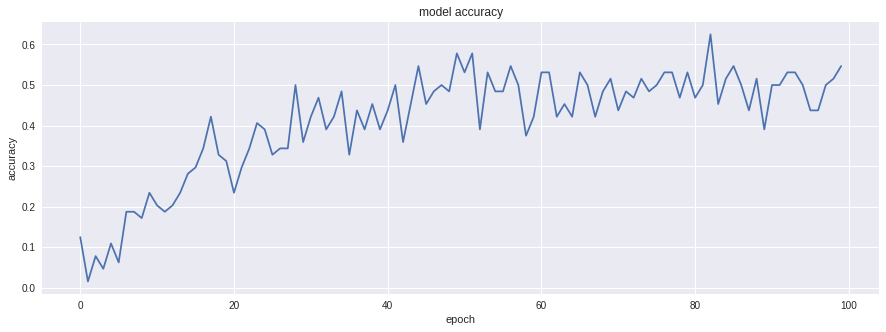

In [ ]:

plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(names, loc='upper left')
axes = plt.gca()
plt.show()

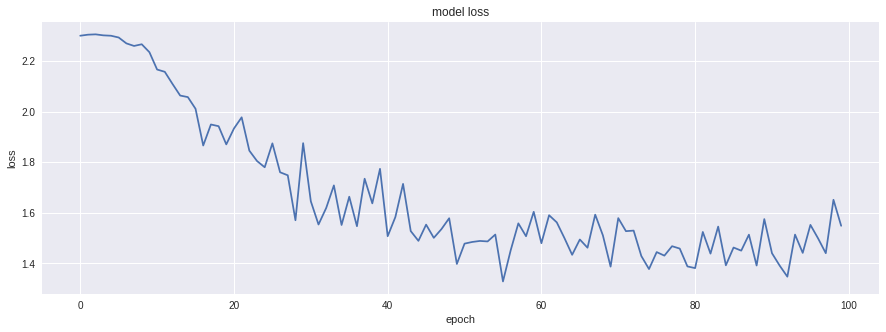

In [ ]:

plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(names, loc='upper left')
axes = plt.gca()
plt.show()

# Resources Used :



* Blog for using Data generators : https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400

*   Plot losses dinamically while training : https://medium.com/@kapilvarshney/how-to-plot-the-model-training-in-keras-using-custom-callback-function-and-using-tensorboard-41e4ce3cb401
 
* Stack overflow for general programming doubts : https://stackoverflow.com/ 

* Official Documentation of python libraries










